In [1]:
import sqlite3
import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

from bgfunc import *

loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.5, for 906 words
loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.0, for 4483 words
loading LabMT with stopVal=1.0, for 3731 words
loading ANEW with stopVal=1.0, for 765 words


/Users/andrew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load SQLite database 

In [2]:
dbfile = 'project_july26.db' # only project_july26.db has up-to-date word feats
conn = sqlite3.connect(dbfile)

## Analysis parameters 

Which condition are we studying?  Are there any cutoffs based on testing?  
What sort of analyses or models do we want to run?

In [3]:
platform = 'tw' # ig = instagram, tw = twitter
condition = 'depression' # depression, pregnancy, ptsd, cancer

In [4]:
specs = analysis_specifications(platform, condition)

platform_long = specs['plong'][platform]
gb_types = specs['gb_types'][platform]
fields = specs['fields'][platform] 
test_name = specs['test_name'][condition]
test_cutoff = specs['test_cutoff'][condition]
photos_rated = specs['photos_rated'][condition]
has_test = specs['has_test'][condition]

clfs = ['rf'] # lr = logistic regression, rf = random forests, svc = support vector
periods = ['before','after']
turn_points = ['from_diag','from_susp']

#################
#
# INSTAGRAM ONLY 
# 
#################
additional_data = False # (instagram only) do we also get photo ratings? (This is proxy for limit_date_range in places)

include_filter = False # (instagram only) include binary indicator of filter use? 

include_face_data = False # (instagram only) include has_face and face_ct? 

get_ratings_correlation = False # (instagram only) gets inter-rater correlation averages for each rated variable 

compare_ig_filters = False # (nstagram only) compares use of filters between target and control pops

#################
#
# TWITTER ONLY 
# 
#################
populate_wordfeats_db = False # (twitter only) generates word features from reagan code 

#################
#
# ALL PLATFORMS 
# 
#################
impose_test_cutoff = True # do we want to limit target pop based on testing cutoff (eg. cesd > 21)?

limit_date_range = False # do we want to restrict posts by date range? 

posting_cutoff = False # Drops usernames with fewer than (mean - 0.5std) total posts (for mcmc p-val improvement)

report_sample_size = False # simple reporting feature for sample size

report_sm_disq = False # reports #/% of subjects disqualified for refusing to share social media data

share_sm_disq_fnames = ["../../data/final/depressiontwitter_round1.csv",
                       "../../data/final/depressiontwitter_round2.csv",
                       "../../data/final/controltwitter.csv"]

path_head = '/'.join(['data-files',condition,platform])+'/'

load_from = 'pickle' # None, file, pickle :: loads masters from pickled file, or just masters from csv

write_to = None # None, file, pickle  :: writes initial data (prepare_raw_data()) to csv or pickle

final_pickle = True # pickles entire data dict after all masters are created

make_hourly_plot = False # make plot of aggregated hourly posting for target vs control?

run_master = True 
run_subsets = True
run_separate_pca = True

action_params = {
    'create_master': True, 
    'save_to_file' : True, 
    'density' : False, 
    'ml' : True, 
    'nhst' : True, 
    'corr' : False, 
    'print_corrmat' : False,
    'tall_plot': True,
    'acc_avg': 'binary',
    'use_ttest':False,
    'best_pca':1,
    'show_pca_comp_plot':True
}

params = define_params(condition, test_name, test_cutoff, impose_test_cutoff,
                       platform, platform_long, fields, photos_rated, has_test, additional_data)

### hourly_plot sets local timestamp for every post 
The timezone acquisition happens in get_timezones.py.  That's not currently imported here, but it should get merged eventually.  to_localtime_wrapper() assumes that the 'tz' field in meta_tw is populated as best as can be done.
Remember not all Twitter accounts have time zone info, and Instagram has none at all, aside from occassional lat/lon data (which we didn't bother to try and convert).  
  
### WARNING: hourly_plot() is not well-constructed, and rewrites meta_tw, leaving some odd results!
In particular, None gets replaced with '' for some reason, and this screws up other things.  Be careful.

In [5]:
if make_hourly_plot:
    hourly_plot(conn)

In [11]:
# printout showing sample sizes for target and control groups
if report_sample_size:
    report_sample_sizes(params, conn, condition, platform_long, test_cutoff, test_name)

SAMPLE SIZES: target populations

TARGET :: DEPRESSION / TWITTER total: 147
TARGET :: DEPRESSION / TWITTER cesd > 21: 114


SAMPLE SIZES: control populations

CONTROL :: DEPRESSION / TWITTER total: 109



In [7]:
if report_sm_disq:
    total_attempted = 0
    total_disq = 0
    
    for fname in share_sm_disq_fnames:
        attempt, disq = report_share_sm_disq(fname)
        total_attempted += attempt
        total_disq += disq
        print

    print
    print 'total attempted survey respondents (including target + control):', total_attempted
    print 'total disqualified for refusing to share social media:', total_disq
    print 'percentage disqualified:', total_disq / float(total_attempted)

Total attempted: 927
Disqualified for share_sm: 393
% disq for share_sm: 0.423948220065

Total attempted: 428
Disqualified for share_sm: 98
% disq for share_sm: 0.228971962617

Total attempted: 906
Disqualified for share_sm: 299
% disq for share_sm: 0.330022075055


total attempted survey respondents (including target + control): 2261
total disqualified for refusing to share social media: 790
percentage disqualified: 0.349402919062


## Load ready data, or prepare raw data

Set load_from to determine action here.  

In case you don't have a pickled data dict or saved csv, or if you want to make a new one, the next block will:

- Pulls data from db
- Aggregates in buckets (day, week, user)
- Creates before/after diag/susp date subsets along with whole

Otherwise we load existing cleaned/aggregated data from pickle/csv

In [5]:
if not load_from: # construct data dict from raw data
    data = make_data_dict(params, condition, test_name, conn)
    prepare_raw_data(data, platform, params, conn, gb_types, condition, 
                     periods, turn_points, posting_cutoff,
                     additional_data=additional_data, include_filter=include_filter, limit_date_range=limit_date_range)
else: # load data dict from saved file
    data = pickle.load(open("{path}{cond}_{pl}_data.p".format(path=path_head,
                                                              cond=condition,
                                                              pl=platform), "rb" ) )

### This next section generates word features from Andy Reagan's code

Only set populate_wordfeats_db = True if you need to redo the features for some reason!
    

In [8]:
if populate_wordfeats_db:
    create_word_feats_wrapper(['target','control'], gb_types, data, condition, conn, 
                              write_to_db=True, testing=True)                        

## Descriptive stats 

Total posts across all groups: 279951
Mean posts per participant: 1372.31 (SD=1281.74)
Median posts per participant: 862.0

POPULATION: TARGET
Total participants analyzed: 105
Total posts: 164218
Mean posts per participant: 1563.98 (SD=1332.02)
Median posts per participant: 1127.0
Earliest date of first diagnosis: 2010-03-16 00:00:00
Latest date of first diagnosis: 2016-02-02 00:00:00
Proportion diagnosed between 2013-2015 (target only): 0.92
Average age: 30.31 (SD=8.34)
Min age: 18
Max age: 64


POPULATION: CONTROL
Total participants analyzed: 99
Total posts: 115733
Mean posts per participant: 1169.02 (SD=1199.59)
Median posts per participant: 574.0
Proportion female (control only): 0.42
Average age: 33.87 (SD=10.09)
Min age: 19
Max age: 63




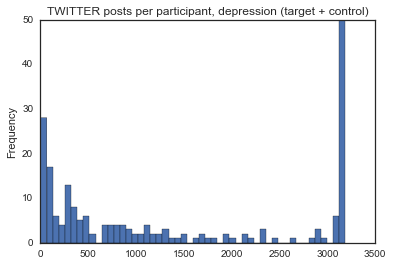

In [6]:
output = get_descriptives(data, condition, platform_long, additional_data, conn, return_output=True)

## Construct master dataset & run analyses

Possible actions:
- generate master data
- save to disk
- plot target vs control densities for each variable
- correlation plot
- ML modeling
- NHST


Merge to master: MAIN created_date
master created_date shape: (102215, 50)

Building ML models...

TN :: (12694.0, 0.0)
PNEG :: (17372.0, 0.0)
NEG :: (15345.0, 0.0)
NPV :: (0.731, 0.0)
SPECIFICITY :: (0.827, 0.0)
PRECISION :: (0.801, 0.0)
RECALL :: (0.695, 0.0)
F1 :: (0.744, 0.0)


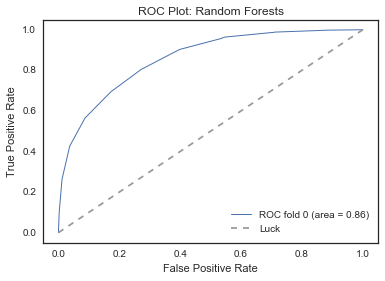

UNIT OF OBSERVATION: CREATED_DATE


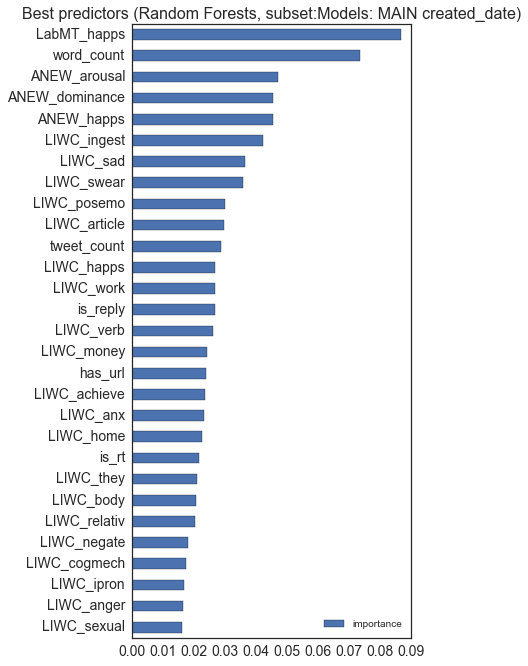

actualpos: 15320
total y_test: 30665
prevalence: 0.49959236915

Out of 100 random observations...

n1 50.0
n0 50.0
35.0 positive IDs
8.0 false alarms
15.0 false negatives
42.0 negative IDs

reconstituted total: 100.0

LOGISTIC REGRESSION
UNIT OF MEASUREMENT: created_date

Optimization terminated successfully.
         Current function value: 0.668815
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               102215
Model:                          Logit   Df Residuals:                   102174
Method:                           MLE   Df Model:                           40
Date:                Mon, 01 Aug 2016   Pseudo R-squ.:                 0.03507
Time:                        13:07:07   Log-Likelihood:                -68363.
converged:                       True   LL-Null:                       -70848.
                                        LLR p-value:                    

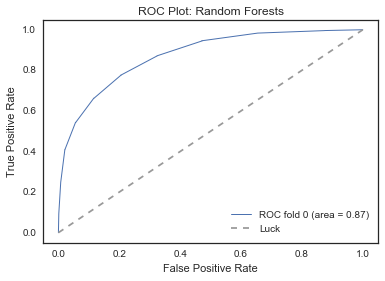

UNIT OF OBSERVATION: WEEKLY


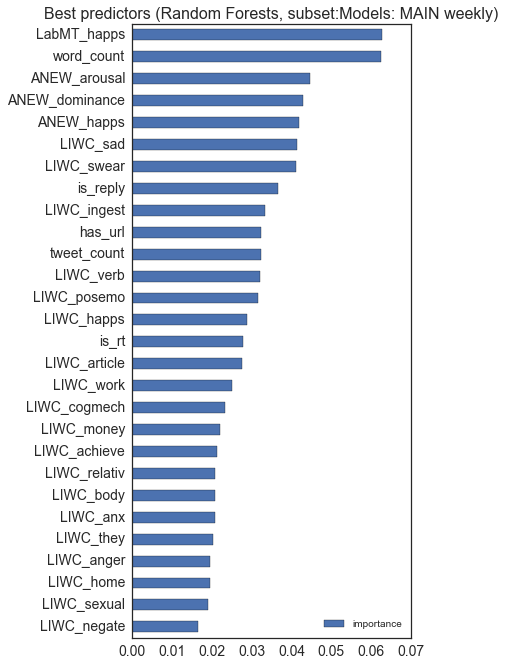

actualpos: 4020
total y_test: 8799
prevalence: 0.456870098875

Out of 100 random observations...

n1 46.0
n0 54.0
31.0 positive IDs
6.0 false alarms
15.0 false negatives
48.0 negative IDs

reconstituted total: 100.0

LOGISTIC REGRESSION
UNIT OF MEASUREMENT: weekly

Optimization terminated successfully.
         Current function value: 0.645188
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                29328
Model:                          Logit   Df Residuals:                    29287
Method:                           MLE   Df Model:                           40
Date:                Mon, 01 Aug 2016   Pseudo R-squ.:                 0.06305
Time:                        13:07:12   Log-Likelihood:                -18922.
converged:                       True   LL-Null:                       -20195.
                                        LLR p-value:                     0.000


In [6]:
if run_master:
    master = data['master']
    target = data['target']['gb']
    control = data['control']['gb'] 
    report = 'MAIN'
    
    if action_params['create_master']:
        master['model'] = {}

    for gb_type in ['created_date', 'weekly']:

        master_actions(master, target, control, condition, platform, 
                       params, gb_type, report, action_params, clfs, additional_data, posting_cutoff, 
                       use_pca=False, scale_data=True)

In [32]:
data['master']['created_date'].target.sum()
#data['master']['created_date'].shape
#a[['user_id','target']].tail()

50766

## Subset master actions

Same as above block, but for subsets, eg. target before diag_date vs controls

Reporting for: SUBSETS
Period: BEFORE  Focus: FROM_DIAG  Groupby: CREATED_DATE (PCA:False)

Merge to master: before-from_diag created_date
master created_date shape: (74990, 50)

Building ML models...

TN :: (14773.0, 0.0)
PNEG :: (18261.0, 0.0)
NEG :: (15405.0, 0.0)
NPV :: (0.809, 0.0)
SPECIFICITY :: (0.959, 0.0)
PRECISION :: (0.851, 0.0)
RECALL :: (0.508, 0.0)
F1 :: (0.636, 0.0)


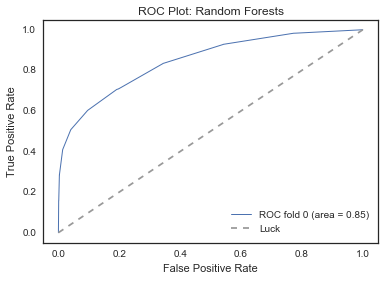

UNIT OF OBSERVATION: CREATED_DATE


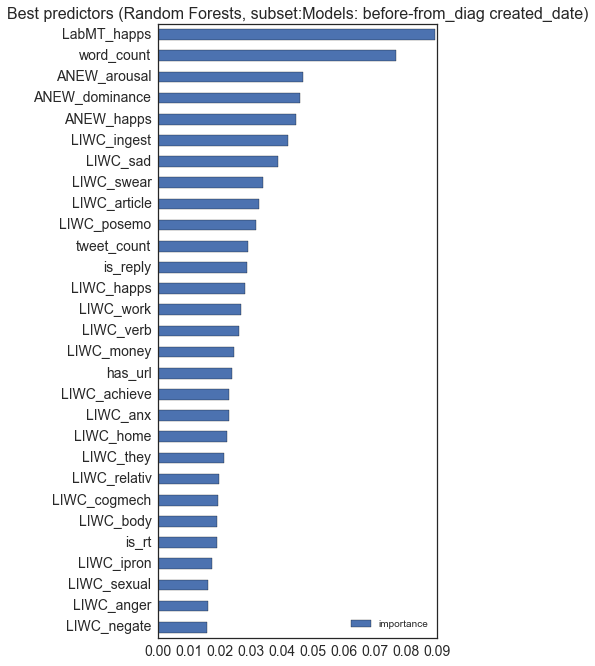

actualpos: 7092
total y_test: 22497
prevalence: 0.315242032271

Out of 100 random observations...

n1 32.0
n0 68.0
17.0 positive IDs
2.0 false alarms
15.0 false negatives
66.0 negative IDs

reconstituted total: 100.0

LOGISTIC REGRESSION
UNIT OF MEASUREMENT: created_date

Optimization terminated successfully.
         Current function value: 0.606531
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                74990
Model:                          Logit   Df Residuals:                    74949
Method:                           MLE   Df Model:                           40
Date:                Mon, 01 Aug 2016   Pseudo R-squ.:                 0.02519
Time:                        13:09:30   Log-Likelihood:                -45484.
converged:                       True   LL-Null:                       -46659.
                                        LLR p-value:                    

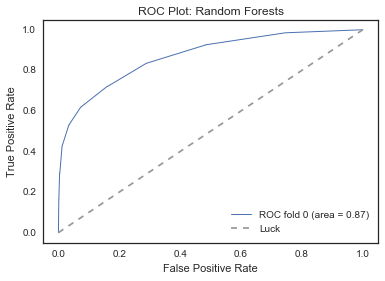

UNIT OF OBSERVATION: WEEKLY


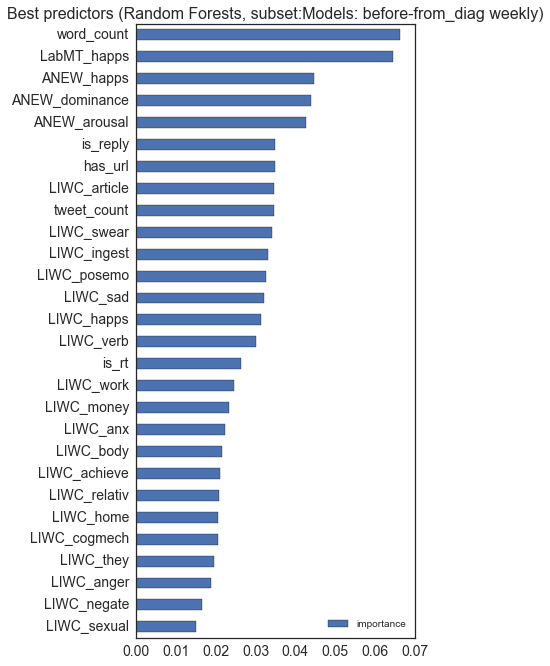

actualpos: 1866
total y_test: 6736
prevalence: 0.277019002375

Out of 100 random observations...

n1 28.0
n0 72.0
15.0 positive IDs
2.0 false alarms
13.0 false negatives
70.0 negative IDs

reconstituted total: 100.0

LOGISTIC REGRESSION
UNIT OF MEASUREMENT: weekly

Optimization terminated successfully.
         Current function value: 0.564149
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                22451
Model:                          Logit   Df Residuals:                    22410
Method:                           MLE   Df Model:                           40
Date:                Mon, 01 Aug 2016   Pseudo R-squ.:                 0.05544
Time:                        13:09:35   Log-Likelihood:                -12666.
converged:                       True   LL-Null:                       -13409.
                                        LLR p-value:                3.950e-286


In [7]:
use_pca = False # should models be fit using orthogonal pca components?

if run_subsets:
    for period in ['before']:
        if action_params['create_master']:
            data['master'][period] = {}

        for turn_point in ['from_diag']:    
            if action_params['create_master']:
                data['master'][period][turn_point] = {}

            master = data['master'][period][turn_point]
            target = data['target'][period][turn_point]['gb']
            control = data['control']['gb'] 
            report = '{}-{}'.format(period,turn_point)

            if action_params['create_master']:
                master['model'] = {}

            for gb_type in ['created_date','weekly']:
                print 'Reporting for: SUBSETS'
                print 'Period: {}  Focus: {}  Groupby: {} (PCA:{})'.format(period.upper(), turn_point.upper(), gb_type.upper(), use_pca)
                # merge target, control, into master
                master_actions(master, target, control, condition, platform, 
                               params, gb_type, report, action_params, clfs, additional_data, posting_cutoff,
                               use_pca, scale_data=True)

### Pickle entire data dict

Set final_pickle = True to save to disk  
Note that this is separate from saving individual files to csv, which is controlled by the save_to_file flag in action_params.

In [13]:
if final_pickle:
    pickle.dump( data, open( "{path}{cond}_{pl}_data.p".format(path=path_head,cond=condition,pl=platform), "wb" ) )

### Within-target before vs after

This compares before/after diag/susp dates within target population.  
Basically just a check to see whether the population looks different based on a given change point

In [11]:
# no username gb because you don't have the infrastructure built (you'd need to split bef/aft before the username gb)
# but at any rate, this is just a check...and per-username groupby has the lowest sample size anyhow
if run_before_after:
    for gb_type in ['created_date','weekly']: 
        before_vs_after(data['target']['gb'], gb_type, platform, condition, params['vars'][platform], action_params)

### PCA

PCA below only runs on master (ie. not before/after diag/susp vs control).

Note: You can fold in PCA into the master_actions() sequence, above, by adding the parameter use_pca=True  
This will only run PCA and PCA components as predictors, though.  
Currently you can't run both PCA and non-PCA when modeling, simulataneously - you did this mainly to cut down on the length of any one given code block output.  
You may find PCA particularly helpful for the timeline groups analysis...

RUNNING PCA: created_date

Total vars: 40
Num components selected by Minka MLE: 39
Cumulative % variance explained per component:
[ 48.96  56.46  60.55  63.62  66.45  68.99  71.12  73.15  75.07  76.94
  78.6   80.16  81.64  83.03  84.41  85.71  86.9   88.02  89.11  90.14
  91.11  92.05  92.94  93.79  94.6   95.36  96.04  96.67  97.29  97.84
  98.38  98.86  99.22  99.42  99.6   99.75  99.85  99.92  99.98]


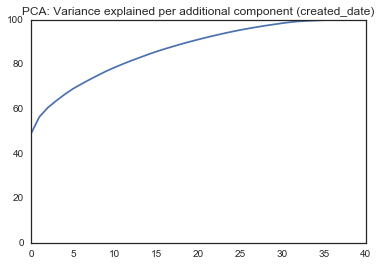

LIWC_article    0.217865
LIWC_sad        0.217559
LIWC_posemo     0.214358
LIWC_ingest     0.213195
LIWC_swear      0.212529
LIWC_verb       0.209143
LIWC_anx        0.198480
LIWC_work       0.197128
LIWC_body       0.193526
LIWC_cogmech    0.192959
Name: PCA_0, dtype: float64

ANEW_happs        0.503621
ANEW_dominance    0.499707
ANEW_arousal      0.479346
LabMT_happs       0.308508
LIWC_happs        0.214144
word_count        0.201466
LIWC_ipron        0.136398
tweet_count       0.085619
LIWC_death        0.073778
LIWC_relig        0.066700
Name: PCA_1, dtype: float64

is_rt             0.631251
is_reply          0.605406
word_count        0.329443
LIWC_i            0.141160
ANEW_dominance    0.140842
ANEW_happs        0.138495
ANEW_arousal      0.130788
LIWC_we           0.089284
LIWC_ipron        0.082997
LabMT_happs       0.073253
Name: PCA_2, dtype: float64

TN :: (12105.0, 0.0)
PNEG :: (16665.0, 0.0)
NEG :: (15526.0, 0.0)
NPV :: (0.726, 0.0)
SPECIFICITY :: (0.78, 0.0)
PRECISION 

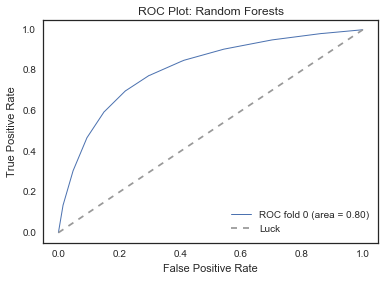


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: CREATED_DATE


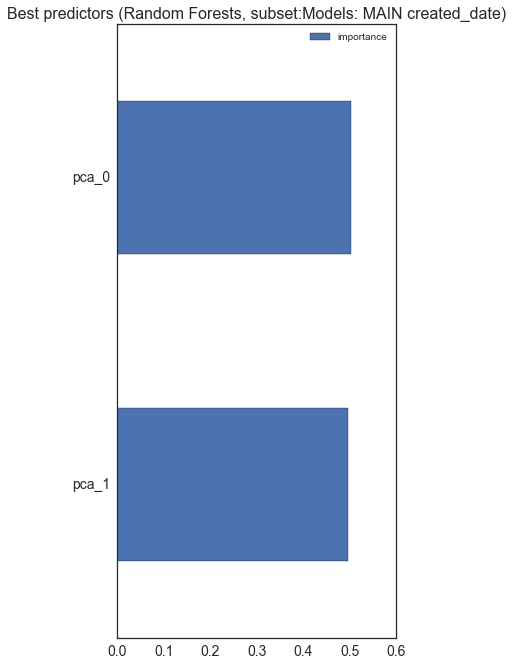

actualpos: 15139
total y_test: 30665
prevalence: 0.49368987445

Out of 100 random observations...

n1 50.0
n0 50.0
35.0 positive IDs
11.0 false alarms
15.0 false negatives
39.0 negative IDs

reconstituted total: 100.0

LOGISTIC REGRESSION
UNIT OF MEASUREMENT: created_date

Optimization terminated successfully.
         Current function value: 0.680643
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               102215
Model:                          Logit   Df Residuals:                   102212
Method:                           MLE   Df Model:                            2
Date:                Mon, 01 Aug 2016   Pseudo R-squ.:                 0.01801
Time:                        10:55:37   Log-Likelihood:                -69572.
converged:                       True   LL-Null:                       -70848.
                                        LLR p-value:                   

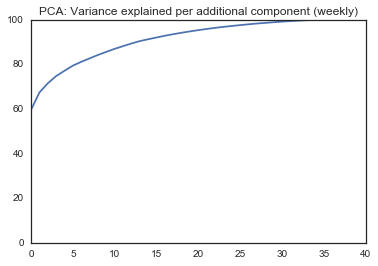

LIWC_sad        0.201293
LIWC_article    0.201084
LIWC_posemo     0.200029
LIWC_ingest     0.199675
LIWC_swear      0.199262
LIWC_verb       0.195779
LIWC_anx        0.193373
LIWC_work       0.192917
LIWC_body       0.192117
LIWC_achieve    0.190781
Name: PCA_0, dtype: float64

ANEW_happs        0.509661
ANEW_dominance    0.505685
ANEW_arousal      0.483160
LabMT_happs       0.308208
LIWC_happs        0.226924
word_count        0.184706
LIWC_ipron        0.172397
tweet_count       0.074690
LIWC_relig        0.056259
LIWC_social       0.050652
Name: PCA_1, dtype: float64

is_rt             0.624528
is_reply          0.618491
word_count        0.387245
LIWC_i            0.122804
ANEW_happs        0.119267
ANEW_dominance    0.116744
ANEW_arousal      0.103619
tweet_count       0.060464
LIWC_we           0.058042
LIWC_ipron        0.057537
Name: PCA_2, dtype: float64

TN :: (4028.0, 0.0)
PNEG :: (5344.0, 0.0)
NEG :: (4884.0, 0.0)
NPV :: (0.754, 0.0)
SPECIFICITY :: (0.825, 0.0)
PRECISION ::

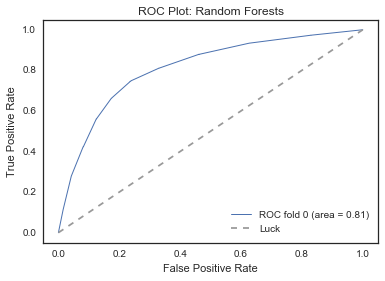


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: WEEKLY


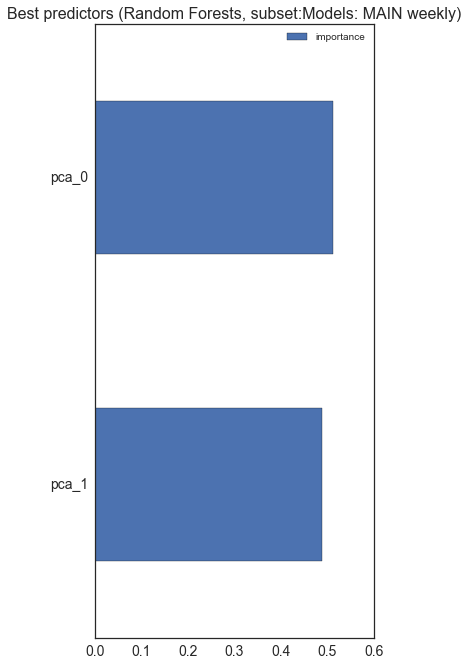

actualpos: 3915
total y_test: 8799
prevalence: 0.444936924651

Out of 100 random observations...

n1 45.0
n0 55.0
30.0 positive IDs
9.0 false alarms
15.0 false negatives
46.0 negative IDs

reconstituted total: 100.0

LOGISTIC REGRESSION
UNIT OF MEASUREMENT: weekly

Optimization terminated successfully.
         Current function value: 0.666501
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                29328
Model:                          Logit   Df Residuals:                    29325
Method:                           MLE   Df Model:                            2
Date:                Mon, 01 Aug 2016   Pseudo R-squ.:                 0.03210
Time:                        10:55:39   Log-Likelihood:                -19547.
converged:                       True   LL-Null:                       -20195.
                                        LLR p-value:                3.117e-282


In [12]:
action_params['best_pca'] = 1

if run_separate_pca:
    master = data['master']
    report = 'MAIN'

    for gb_type in ['created_date','weekly']:

        print 'RUNNING PCA: {}'.format(gb_type)
        print
        model_df = {'name':'Models: {} {}'.format(report, gb_type),
                    'unit':gb_type,
                    'data':master[gb_type],
                    'features':params['vars'][platform][gb_type]['means'],
                    'target':'target',
                    'platform':platform,
                    'test_size':.3,
                    'acc_avg':'binary',
                    'best_pca_num_comp':action_params['best_pca'],#(adds 1 to value); opt 69 tw-MAIN-created_date, but 2 works!
                    'show_pca_comp_plot':action_params['show_pca_comp_plot'],
                    'kernel':'rbf',
                    'tall_plot':action_params['tall_plot'],
                    'rf_params': {'class_wt':'balanced',
                                  'max_feat':'sqrt',
                                  'n_est':10,
                                  'min_ss':2,
                                  'min_sl':1,
                                  'max_depth':None,
                                  'imp_cutoff':.015} # params optimized with 5-fold CV, see optimize_rf_hyperparams()
                   }

        excluded_set = params['model_vars_excluded'][platform][gb_type]

        output, pca_df, best_f1, master_results = make_models(model_df, clf_types=clfs, 
                                                           excluded_set=excluded_set, 
                                                           use_pca=True)
        
        save_master_to_file(additional_data, posting_cutoff, run_separate_pca, action_params['best_pca']+1,
                            gb_type, report, condition, platform, pca_df)
        
        print
        print 'LOGISTIC REGRESSION'
        print logreg_wrapper(pca_df, gb_type, None, None, additional_data='pca')


In [39]:
cols = ['actual depressed','actual healthy','correct depressed','false pos','false neg','correct healthy']
a = pd.DataFrame(np.array([50,50,35,8,15,42]), columns=['all_data'], index=cols)
a['pca_2_comp'] = np.array([50,50,35,10,15,40])
a['pca_5_comp'] = np.array([50,50,35,9,15,41])
a['pca_10_comp'] = np.array([50,50,35,9,15,41])

a.sort_index()

,all_data,pca_2_comp,pca_5_comp,pca_10_comp
actual depressed,50,50,50,50
actual healthy,50,50,50,50
correct depressed,35,35,35,35
correct healthy,42,40,41,41
false neg,15,15,15,15
false pos,8,10,9,9
